### 프로젝트: 고양이 수염 스티커 만들기

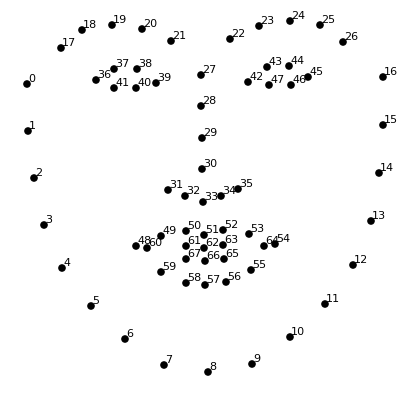

In [ ]:
# Dlib 모델 다운로드
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -d ./shape_predictor_68_face_landmarks.dat.bz2

--2023-07-13 01:05:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  25.3MB/s    in 2.4s    

2023-07-13 01:05:07 (25.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# 필요 라이브러리 import

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import copy

In [ ]:
class sticker_photo:
  def __init__(self , img):
    # detector를 선언합니다 , dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옵니다.
    self.detector_hog = dlib.get_frontal_face_detector()
    self.landmark_predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
    # OpenCV로 이미지를 불러옵니다 , 그리고 BGR 형태의 이미지를 RGB 로 바꿉니다.
    img = cv2.imread(img)
    self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # pred_face 함수를 먼저 실행 했는지 알기위해서 선언한 변수 / 실행이 되었다면 값이 1 로 변경됨
    self.status = 0


  def pred_face(self):

    # 바운딩박스, 영역을 그리기 위해 이미지 복사 (스티커를 그릴때는 박스를 표시안할것임)
    cp_img = copy.deepcopy(self.img)

    self.list_landmarks = []

    # detector_hog를 이용해서 얼굴의 bounding box를 추출합니다
    self.dlib_rects = self.detector_hog(cp_img, 1)

    # dlib_rects 값이 있을 경우 얼굴이 Detection 되었다고 생각하고 아래의 코드 수행, status 상태 1로 변경
    if self.dlib_rects :

      self.status = 1

      for dlib_rect in self.dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

      # 얼굴 영역 박스 마다 face landmark를 찾아냅니다 그리고 모든 landmark의 위치정보를 points 변수에 저장
      for dlib_rect in self.dlib_rects:
        points = self.landmark_predictor(cp_img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        self.list_landmarks.append(list_points)

      # list_landmarks의 원소의 갯수만큼 반복문 실행
      for landmark in self.list_landmarks:
          for point in landmark:
            cv2.circle(cp_img, point, 2, (0, 255, 255), -1)
      cv2.rectangle(cp_img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림


    # dlib_rects 값이 없을 경우 얼굴이 Detection 되지 않았다 생각하고 아래의 코드 수행 , status 상태 0으로 변경
    else :
      print('검출 된 얼굴이 없습니다. 다른 사진으로 시도해주세요')
      self.status = 0

    plt.imshow(cp_img)
    plt.show()

  def draw_sticker(self, sticker = cv2.imread('./cat-whiskers.png')):

    weight = 0.5

    # status 가 1인 경우 아래 코드 수행
    if self.status :

        # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
        for dlib_rect, landmark in zip(self.dlib_rects, self.list_landmarks):
          w = h = dlib_rect.width() # 코의 좌우 크기를 비율로 사이즈 조절
          x = landmark[30][0] - w//2 # 이미지에서 코 부위의 x값 - 얼굴의 가로 영역을 차지하는 픽셀 수 //2
          y = (landmark[30][1]+landmark[33][1])//2 - h//2  # 이미지에서 코 부위에 해당하는 30,33 픽셀의 중앙 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2

          # 스티커가 원본사진을 넘어가면 잘라냄
          if x < 0:
              sticker = sticker[:, -x:]
              x = 0
          if y < 0:
              sticker = sticker[-y:, :]
              y = 0

          sticker = cv2.resize(sticker, (w,h)) # 스티커 크기 조절

          # 스티커 부착할 영역을 지정
          sticker_area = self.img[y:y+sticker.shape[0], x:x+sticker.shape[1]]
          # 두개의 이미지에 각각의 가중치를 조절하여 덧셈 , 가중치가 큰 이미지가 더 선명하다.
          add_W_sticker = cv2.addWeighted(sticker_area, 1- weight, sticker, weight, 0)

          self.img[y:y+sticker.shape[0], x:x+sticker.shape[1]] = np.where(sticker!=0,sticker_area,add_W_sticker).astype(np.uint8)

          plt.imshow(self.img)
          plt.show()


    # status가 0 인경우
    else :
      print('pred_face() 함수를 먼저 수행해주세요')


In [ ]:
# 강아지 사진
model = sticker_photo('./1.jpg')

In [ ]:
model.draw_sticker()

pred_face() 함수를 먼저 수행해주세요


검출 된 얼굴이 없습니다. 다른 사진으로 시도해주세요


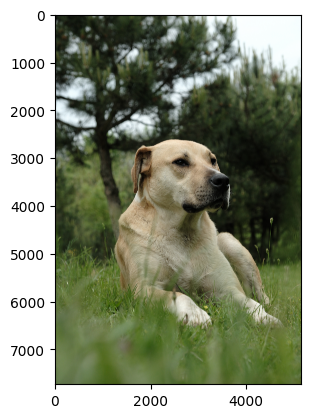

In [ ]:
model.pred_face()

In [ ]:
# 사람 사진
model = sticker_photo('2.jpg')

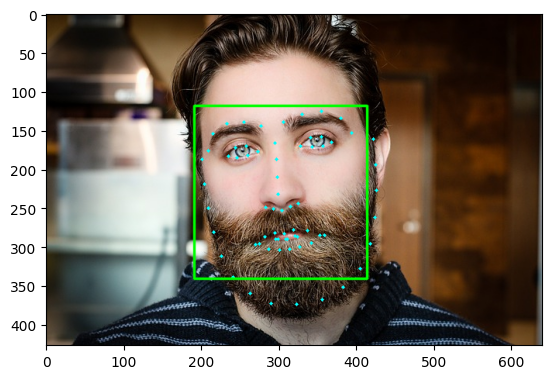

In [ ]:
# bounding box 그리기
model.pred_face()

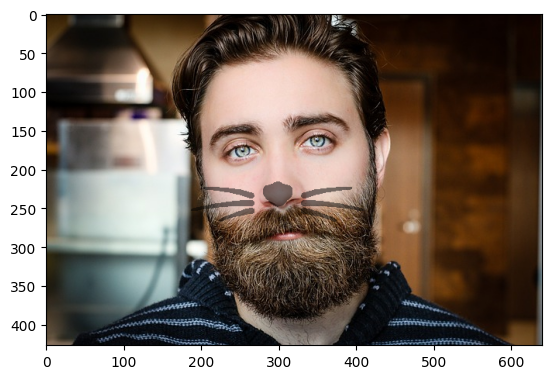

In [ ]:
# 스티커 붙이기
model.draw_sticker()

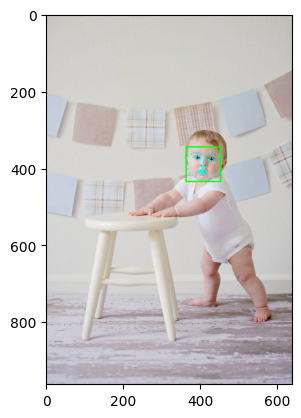

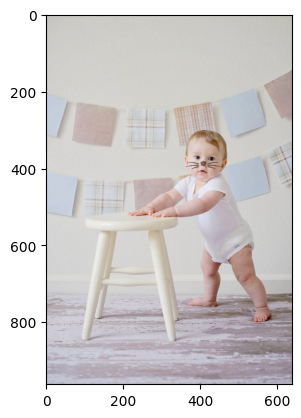

In [ ]:
# 다른 사진으로 테스트

# 1) 어린이 사진

model = sticker_photo('3.jpg')

model.pred_face()

model.draw_sticker()

검출 된 얼굴이 없습니다. 다른 사진으로 시도해주세요


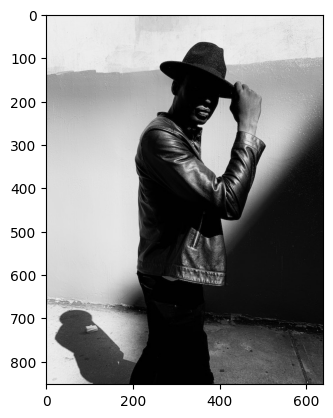

pred_face() 함수를 먼저 수행해주세요


In [ ]:
# 2) 어두운 사진 (잘 안된다.)

model = sticker_photo('4.jpg')

model.pred_face()

model.draw_sticker()

검출 된 얼굴이 없습니다. 다른 사진으로 시도해주세요


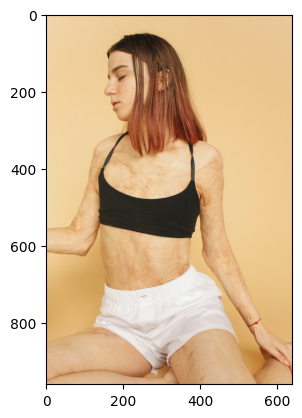

pred_face() 함수를 먼저 수행해주세요


In [ ]:
# 3) 측면 사진 (잘 안된다.)

model = sticker_photo('5.jpg')

model.pred_face()

model.draw_sticker()

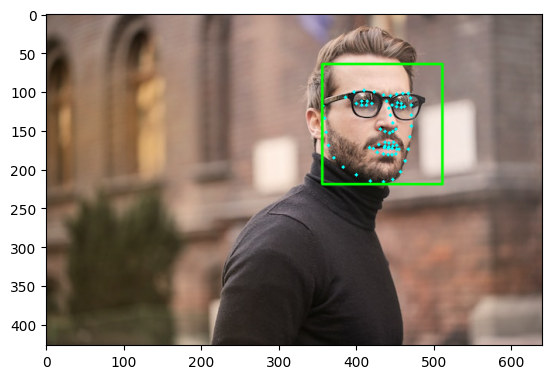

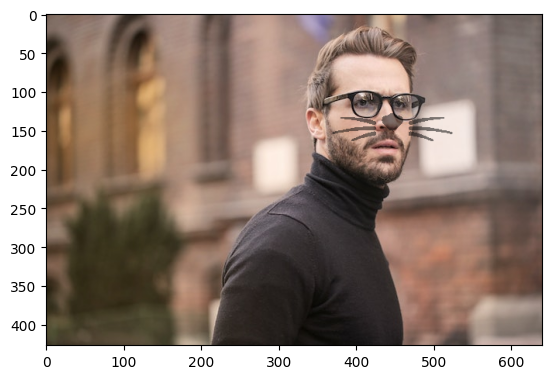

In [ ]:
# 4) 측면 사진

model = sticker_photo('7.jpg')

model.pred_face()

model.draw_sticker()

In [ ]:
# 밝기, 얼굴의 각도에 따라 Detection의 성능이 차이가 남
# 살짝 틀어진 얼굴은 Detection이 가능했으나 스티커의 위치를 변화시켜줄 코드 개발이 필요함

# 이후 개선 사항
# -> 측면 얼굴에서 스티커를 적용했을때 스티커를 어떻게 보정해줄것인가?
# -> Detection 성능을 높일 방법은?
# -> 어두운 사진이 들어왔을때 밝기를 보정해줄 방법은 어떤것들이 있을까?
# -> 과정을 보여주기 위해 Detection 과정과 스티커를 적용하는 함수를 분리해두었는데, 하나로 합치면 깔끔할것같다.